In [1]:
%load_ext rpy2.ipython

In [10]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core'


nprocs = 20

In [11]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

#### Read in sample metadata and OTU table

In [86]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != 'PAS') & (physeq.Bulk.m$Sample_Date == '9/24/14'),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk= filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)



physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5092 taxa and 16 samples ]
sample_data() Sample Data:       [ 16 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 5092 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 5092 tips and 5091 internal nodes ]


### Adonis stats

In [87]:
%%R
library(vegan)
wunif = phyloseq::distance(physeq.Bulk, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Run 0 stress 0.06786116 
Run 1 stress 0.06786126 
... procrustes: rmse 0.0001392935  max resid 0.0003754436 
*** Solution reached


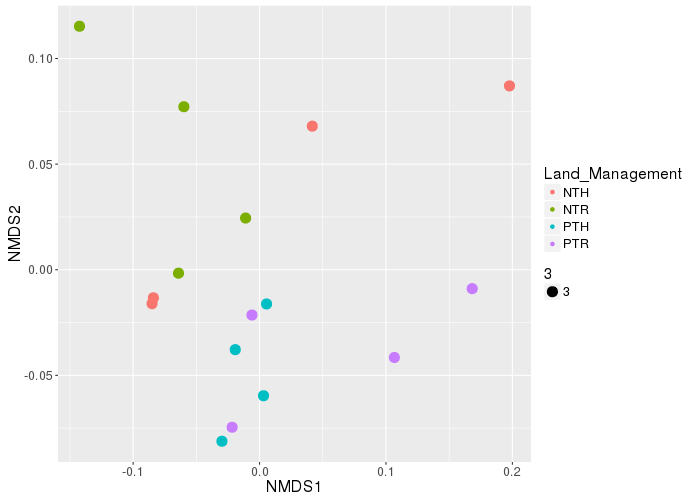

In [90]:
%%R -w 700 -h 500
nmds = ordinate(physeq.Bulk, 
                method = "NMDS", 
                distance = wunif)

p.nmds = plot_ordination(physeq.Bulk, nmds, justDF = TRUE)

asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmds1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
         geom_point((aes(color = Land_Management, size = 3))) +
         guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
         theme(text = element_text(size = 16))

print(p.nmds1)

In [89]:
%%R 
physeq.data = as(sample_data(physeq.Bulk), "data.frame")
adonis(wunif ~ Till + Replicate, physeq.data)


Call:
adonis(formula = wunif ~ Till + Replicate, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)  
Till       1  0.044772 0.044772 3.15185 0.18671  0.011 *
Replicate  1  0.010359 0.010359 0.72924 0.04320  0.614  
Residuals 13  0.184665 0.014205         0.77009         
Total     15  0.239795                  1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [93]:
%%R
test = estimate_richness(physeq.Bulk, split = TRUE)
test$Sample = rownames(test)
test = test %>% tidyr::separate(Sample, c('Month', 'Treatment', 'Rep'))

In [94]:
%%R
head(test)

        Observed    Chao1 se.chao1      ACE   se.ACE  Shannon   Simpson
S.NTR.2     3182 3811.137 55.65925 3883.461 29.46466 7.016489 0.9971283
S.PTR.2     3196 3947.360 64.66301 3966.131 30.01234 7.189940 0.9981007
S.NTH.1     3132 3900.071 66.45258 3924.332 30.26083 6.998353 0.9973642
S.NTH.4     3323 4085.417 64.79678 4123.812 30.76326 7.017203 0.9967359
S.PTR.4     3644 4089.347 51.24778 3947.743 30.94050 7.107449 0.9976969
S.NTR.3     3878 4524.472 55.92340 4548.194 31.33413 7.302915 0.9982566
        InvSimpson    Fisher Month Treatment Rep
S.NTR.2   348.2243  978.4113     S       NTR   2
S.PTR.2   526.4968 1043.1794     S       PTR   2
S.NTH.1   379.3844  959.7697     S       NTH   1
S.NTH.4   306.3664 1012.2035     S       NTH   4
S.PTR.4   434.1905  783.5436     S       PTR   4
S.NTR.3   573.5950 1125.4720     S       NTR   3


In [120]:
%%R
test$Till = ifelse(test$Treatment %in% c('NTH', 'NTR'), "N", 'P')
test %>% group_by(Till) %>% summarise(mean(Shannon), sd(Shannon), mean(Observed), sd(Observed), mean(Chao1), sd(Chao1))

Source: local data frame [2 x 7]

   Till mean(Shannon) sd(Shannon) mean(Observed) sd(Observed) mean(Chao1)
  (chr)         (dbl)       (dbl)          (dbl)        (dbl)       (dbl)
1     N      7.011095   0.1693223       3010.375     489.4063    3669.110
2     P      7.163977   0.1219289       3289.250     381.9288    3993.234
Variables not shown: sd(Chao1) (dbl)


In [102]:
%%R
head(test)

        Observed    Chao1 se.chao1      ACE   se.ACE  Shannon   Simpson
S.NTR.2     3182 3811.137 55.65925 3883.461 29.46466 7.016489 0.9971283
S.PTR.2     3196 3947.360 64.66301 3966.131 30.01234 7.189940 0.9981007
S.NTH.1     3132 3900.071 66.45258 3924.332 30.26083 6.998353 0.9973642
S.NTH.4     3323 4085.417 64.79678 4123.812 30.76326 7.017203 0.9967359
S.PTR.4     3644 4089.347 51.24778 3947.743 30.94050 7.107449 0.9976969
S.NTR.3     3878 4524.472 55.92340 4548.194 31.33413 7.302915 0.9982566
        InvSimpson    Fisher Month Treatment Rep Till
S.NTR.2   348.2243  978.4113     S       NTR   2    N
S.PTR.2   526.4968 1043.1794     S       PTR   2    P
S.NTH.1   379.3844  959.7697     S       NTH   1    N
S.NTH.4   306.3664 1012.2035     S       NTH   4    N
S.PTR.4   434.1905  783.5436     S       PTR   4    P
S.NTR.3   573.5950 1125.4720     S       NTR   3    N


In [110]:
%%R
t.test(test$Simpson~test$Till)


	Welch Two Sample t-test

data:  test$Simpson by test$Till
t = -1.8101, df = 11.26, p-value = 0.09702
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.001363283  0.000130955
sample estimates:
mean in group N mean in group P 
      0.9972934       0.9979095 



In [111]:
%%R
physeq.NTH = prune_samples(physeq.Bulk.m$Land_Management == 'NTH',
                           physeq.Bulk)

physeq.PTH = prune_samples(physeq.Bulk.m$Land_Management == 'PTH',
                           physeq.Bulk)

In [112]:
%%R
library(picante)

otu_tab.13CN = t(otu_table(physeq.NTH)) %>% as.data.frame
tree.13CN = (phy_tree(physeq.NTH))

otu_tab.13CP = t(otu_table(physeq.PTH)) %>% as.data.frame
tree.13CP = (phy_tree(physeq.PTH))


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ape

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: nlme

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘nlme’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:IRanges’:

    collapse


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:dplyr’:

    collapse


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [113]:
%%R
pd.13CN = pd(otu_tab.13CN, tree.13CN)
pd.13CP = pd(otu_tab.13CP, tree.13CP)

In [114]:
%%R
pd.13CN$Sample = rownames(pd.13CN)
pd.13CN = pd.13CN %>% separate(Sample, c("Month", "Land_Management", "Replicate")) 

pd.13CN.arr = arrange(pd.13CN, Replicate)
pd.13CN.arr

pd.13CN %>% group_by(Land_Management) %>% summarise(mean_PD = mean(PD), sd_PD = sd(PD))

Source: local data frame [1 x 3]

  Land_Management  mean_PD    sd_PD
            (chr)    (dbl)    (dbl)
1             NTH 159.5993 20.34767


In [115]:
%%R
pd.13CP$Sample = rownames(pd.13CP)
pd.13CP = pd.13CP %>% separate(Sample, c("Month", "Land_Management", "Replicate")) 

pd.13CP.arr = arrange(pd.13CP, Replicate)
pd.13CP.arr

pd.13CP %>% group_by(Land_Management) %>% summarise(mean_PD = mean(PD), sd_PD = sd(PD))

Source: local data frame [1 x 3]

  Land_Management  mean_PD    sd_PD
            (chr)    (dbl)    (dbl)
1             PTH 174.9873 19.13311


In [116]:
%%R
t.test(pd.13CN.arr$PD, pd.13CP.arr$PD, paired = TRUE)


	Paired t-test

data:  pd.13CN.arr$PD and pd.13CP.arr$PD
t = -0.92303, df = 3, p-value = 0.4241
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -68.44355  37.66742
sample estimates:
mean of the differences 
              -15.38806 



In [117]:
%%R
#H - Shannons, S - Species Richness, J = Pielou's evenness

H.13CN <- diversity(otu_tab.13CN )
## Species richness (S) and Pielou's evenness (J):
S.13CN <- specnumber(otu_tab.13CN ) ## rowSums(BCI > 0) does the same...
J.13CN <- H.13CN/log(S.13CN)

J.13CN <- J.13CN[c(1,3,4,2)]

print(mean(J.13CN))
print(sd(J.13CN))

[1] 0.8785315
[1] 0.01420708


In [118]:
%%R
#H - Shannons, S - Species Richness, J = Pielou's evenness
H.13CP <- diversity(otu_tab.13CP)
## Species richness (S) and Pielou's evenness (J):
S.13CP <- specnumber(otu_tab.13CP) ## rowSums(BCI > 0) does the same...
J.13CP <- H.13CP/log(S.13CP)

J.13CP <- J.13CP[c(4,3,1,2)]

J.13CP

print(mean(J.13CP))
print(sd(J.13CP))

[1] 0.892569
[1] 0.007726539


In [119]:
%%R
t.test(J.13CN, J.13CP, paired = TRUE)


	Paired t-test

data:  J.13CN and J.13CP
t = -1.5843, df = 3, p-value = 0.2113
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04223502  0.01415988
sample estimates:
mean of the differences 
            -0.01403757 



## CV calculations

In [132]:
%%R

physeq.both = prune_samples(physeq.Bulk.m$Land_Management %in% c('NTH', 'PTH'),
                           physeq.Bulk)
mdf = psmelt(physeq.both)
head(mdf)

         OTU  Sample Abundance Full.sample Fraction PrimerF PrimerR Barcode
2845  OTU.12 S.NTH.4       798     S.NTH.4       NA    515f    806r     143
28831 OTU.37 S.NTH.4       707     S.NTH.4       NA    515f    806r     143
2848  OTU.12 S.PTH.3       488     S.PTH.3       NA    515f    806r     150
28828 OTU.37 S.PTH.3       480     S.PTH.3       NA    515f    806r     150
37139 OTU.75 S.NTH.1       459     S.NTH.1       NA    515f    806r     139
28832 OTU.37 S.NTH.2       452     S.NTH.2       NA    515f    806r     140
      Rev.index Fwd.index Treatment Day Replicate Pool Land_Management Gradient
2845   ctgcgtag  gatcgtgt      <NA>  NA         4    5             NTH     <NA>
28831  ctgcgtag  gatcgtgt      <NA>  NA         4    5             NTH     <NA>
2848   tagtctcc  tcgacgag      <NA>  NA         3    5             PTH     <NA>
28828  tagtctcc  tcgacgag      <NA>  NA         3    5             PTH     <NA>
37139  ctgcgtag  agagtcac      <NA>  NA         1    5             N

In [133]:
%%R
CV.OTU = mdf %>%  group_by(OTU) %>% 
    summarise(mean = mean(Abundance), sd = sd(Abundance), cv = (sd/mean))

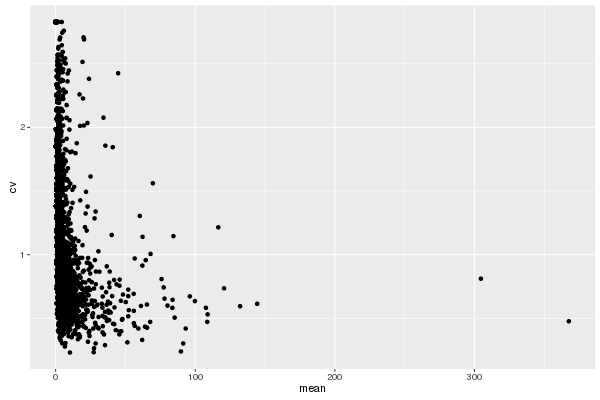

In [134]:
%%R -w 600 -h 400
ggplot() + geom_point(data= CV.OTU, aes(x = mean, y = cv)) 

In [135]:
%%R
CV = mdf %>% group_by(OTU, Till) %>% 
    summarise(mean = mean(Abundance), sd = sd(Abundance), cv = (sd/mean))

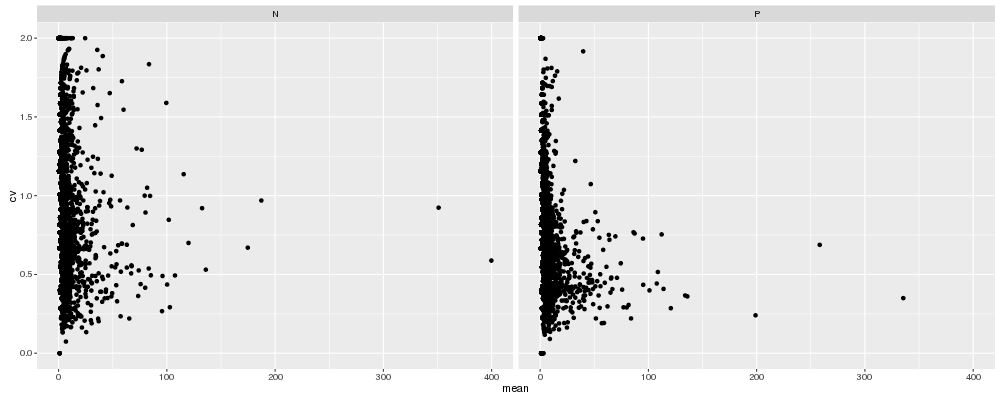

In [136]:
%%R -w 1000 -h 400
ggplot() + geom_point(data= CV, aes(x = mean, y = cv)) + facet_wrap(~Till)

In [137]:
%%R
CV %>% na.omit %>% group_by(Till) %>% summarise(meanCV = mean(cv), sdcv = sd(cv))

Source: local data frame [2 x 3]

    Till   meanCV      sdcv
  (fctr)    (dbl)     (dbl)
1      N 1.237459 0.5165537
2      P 1.091572 0.5366823


In [141]:
%%R
t.test(CV$cv ~ CV$Till)


	Welch Two Sample t-test

data:  CV$cv by CV$Till
t = 13.495, df = 9478.9, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1246970 0.1670784
sample estimates:
mean in group N mean in group P 
       1.237459        1.091572 



In [138]:
%%R
library(e1071)                    
CV %>% na.omit %>% group_by(Till) %>% summarise(skewness = skewness(cv))

Source: local data frame [2 x 2]

    Till  skewness
  (fctr)     (dbl)
1      N 0.1440207
2      P 0.4607640


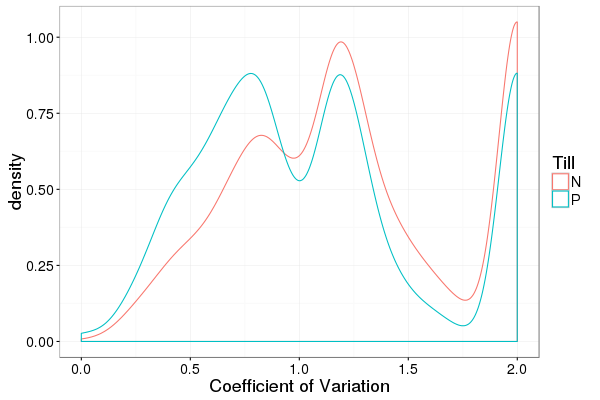

In [139]:
%%R -w 600 -h 400
ggplot() + geom_density(data = CV, aes(cv, color = Till)) +theme_bw() + theme(text = element_text(size=18))+
xlab('Coefficient of Variation') + scale_fill_discrete(name = 'Land Management')


### Log-fold Change Calculations

In [19]:
%%R
get_l2fc = function(physeq.obj, Month, Year, sparsity_threshold) {
    physeq.md = sample_data(physeq.obj)
  
  
    p = prune_samples((physeq.md$Month == Month) &
                      (physeq.md$Year == Year), physeq.obj)
   
    p = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Till)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}

In [20]:
%%R

sdm = physeq.Bulk %>% sample_data %>% 
    filter(! is.na(Till)) %>%
    select(Month, Year) %>%
    distinct() %>%
    arrange(Year, Month) 

sdm %>% nrow %>% print
sdm %>% head(n=5)


[1] 1
      Month Year
1 September 2014


In [21]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Month, Year, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Month', 'Year'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
head(sdms) 

Number of pairwise combinations of variables: 19 

      Month Year sparsity_threshold
1 September 2014               0.05
2 September 2014               0.10
3 September 2014               0.15
4 September 2014               0.20
5 September 2014               0.25
6 September 2014               0.30


In [22]:
%%R
#For testing method
test = head(sdms, 2)
test

      Month Year sparsity_threshold
1 September 2014               0.05
2 September 2014               0.10


In [23]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [75,592 x 15]

       Month  Year sparsity_threshold       OTU log2FoldChange     lfcSE
       (chr) (chr)              (dbl)     (chr)          (dbl)     (dbl)
1  September  2014               0.05  OTU.4940     -2.6819354 1.7632850
2  September  2014               0.05  OTU.4163     -0.8231493 1.7060963
3  September  2014               0.05  OTU.5493      1.9089274 1.5440351
4  September  2014               0.05  OTU.1739      1.2044031 1.6640375
5  September  2014               0.05  OTU.1813     -0.5266578 1.2661866
6  September  2014               0.05 OTU.27780     -1.3588501 1.6296158
7  September  2014               0.05   OTU.778     -1.3937224 0.4822499
8  September  2014               0.05  OTU.5511      0.8994520 1.1607163
9  September  2014               0.05  OTU.6957      2.5038346 1.7616971
10 September  2014               0.05 OTU.11282      1.9315887 1.5280823
..       ...   ...                ...       ...            ...       ...
Variables n

In [24]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    meanl2fc
       (dbl)
1 0.02322075


In [25]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 1.475397


In [26]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [27]:
%%R
df.l2fc$Till[df.l2fc$log2FoldChange > 0] = "PT"
df.l2fc$Till[df.l2fc$log2FoldChange <0] = "NT"

In [28]:
%%R
write.table(df.l2fc, "data/l2fc_NTvsPT_Sept2014", row.names = FALSE, sep = ",")

In [29]:
%%R
df.l2fc = read.table("data/l2fc_NTvsPT_Sept2014", header = TRUE, sep = ",")

In [30]:
%%R
df.l2fc$Rank2 = gsub("__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("__", "", df.l2fc$Rank7)

In [31]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold, Month, Year) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 4]

  sparsity_threshold     Month  Year n_reject_hypo
               (dbl)    (fctr) (int)         (int)
1               0.05 September  2014            29
2               0.10 September  2014            33
3               0.15 September  2014            41
4               0.20 September  2014            55
5               0.25 September  2014            64
6               0.30 September  2014            64


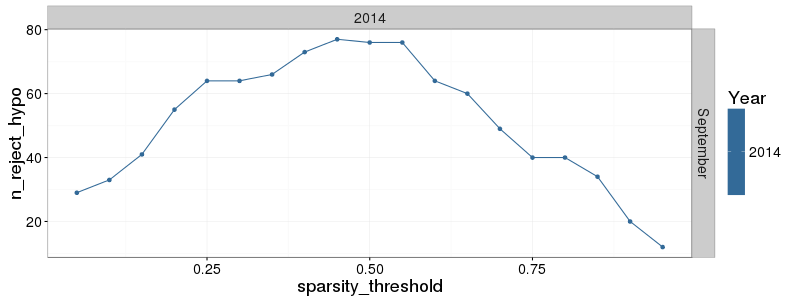

In [33]:
%%R -w 800 -h 300

df.l2fc.rejH$Month = reorder(df.l2fc.rejH$Month, df.l2fc.rejH$Month %>% as.numeric)

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(aes(color= Year)) +
    geom_line(aes(color = Year)) +
    facet_grid(Month ~ Year, scales = "free_y") +
    theme_bw() +
    theme(
        text = element_text(size=18)
        )

In [34]:
%%R
head(df.l2fc.rejH)

Source: local data frame [6 x 4]

  sparsity_threshold     Month  Year n_reject_hypo
               (dbl)    (fctr) (int)         (int)
1               0.05 September  2014            29
2               0.10 September  2014            33
3               0.15 September  2014            41
4               0.20 September  2014            55
5               0.25 September  2014            64
6               0.30 September  2014            64


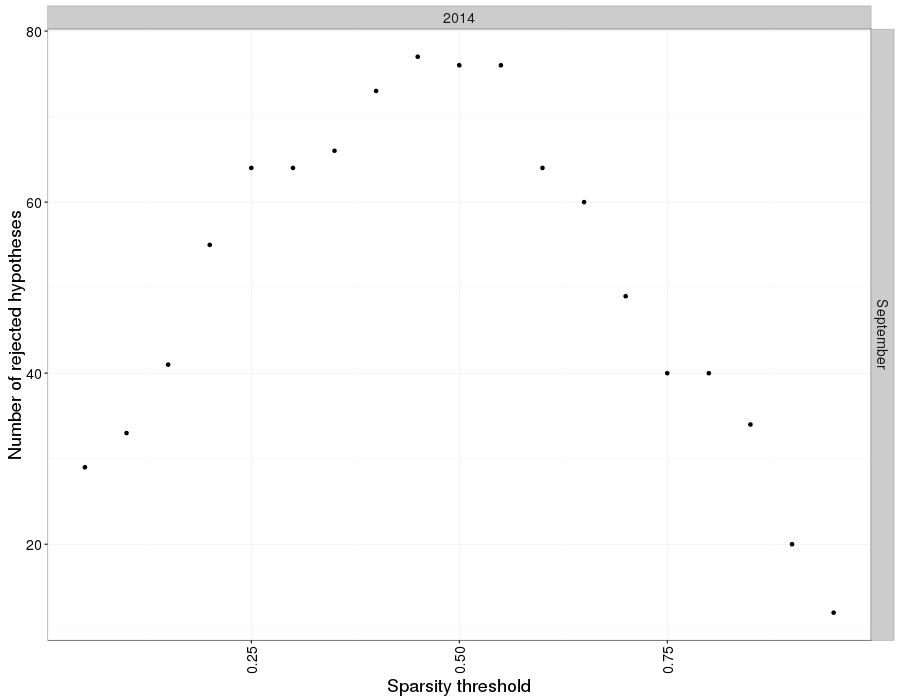

In [35]:
%%R -w 900 -h 700

df.l2fc.rejH = df.l2fc.rejH %>%
    mutate(Month = as.character(Month))

df.l2fc.rejH$Month = reorder(df.l2fc.rejH$Month, df.l2fc.rejH$Month %>% as.numeric)

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point() +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    facet_grid(Month ~ Year,scales = "free_y" ) +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

In [36]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% head(n=3) %>% as.data.frame

  sparsity_threshold n_reject_hypo
1               0.05            29
2               0.10            33
3               0.15            41


In [37]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.45


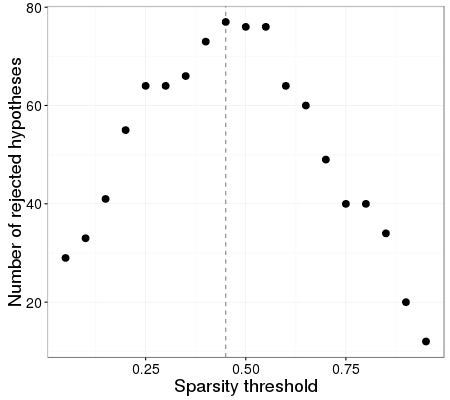

In [38]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [39]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) 

df.l2fc.f %>% nrow

[1] 3314


In [40]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_sparse-maxRejH_Sept2014.txt'
write.table(df.l2fc.f, 'data/l2fc_sparse-maxRejH_Sept2014.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [41]:
%%R
df.l2fc = read.table('data/l2fc_sparse-maxRejH_Sept2014.txt', sep='\t', header = TRUE)

In [42]:
%%R
df.l2fc$Rank2 = gsub("__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("__", "", df.l2fc$Rank7)

In [43]:
%%R
test = filter(df.l2fc, padj2<=0.10)
print(length(unique(test$OTU)))
print(length(unique(df.l2fc$OTU)))

[1] 77
[1] 3314


In [44]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Month, Year, Till) %>% summarise(resp = n())
resp$treat = "a"
resp %>% ungroup() %>% arrange(resp) %>% as.data.frame

      Month Year Till resp treat
1 September 2014   NT   20     a
2 September 2014   PT   57     a


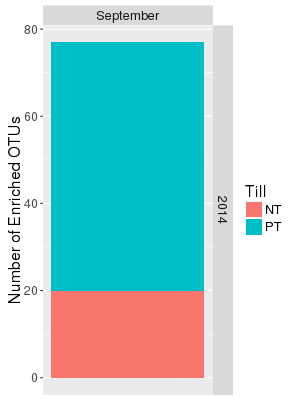

In [46]:
%%R -w 300 -h 400
p = ggplot(data = resp, aes(x = treat, y = resp)) +
    geom_bar(stat = 'identity', aes(fill = Till), position = 'stack') + facet_grid(Year~Month, scales = 'fixed')+
    theme(text = element_text(size=16)) + ylab("Number of Enriched OTUs") + scale_x_discrete(breaks=NULL) + xlab(NULL)
p

In [33]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime.jpg", plot = p, width =12, height =6)

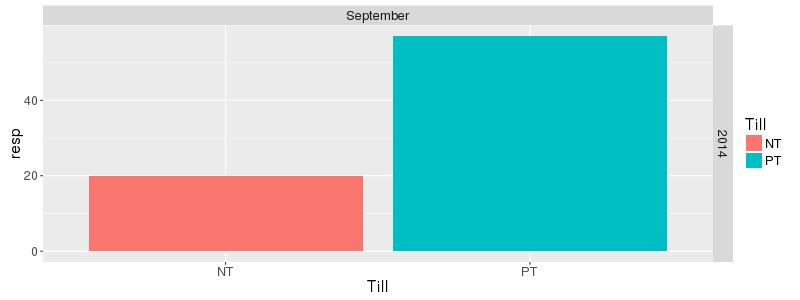

In [47]:
%%R -w 800 -h 300
ggplot(data = resp, aes(x = Till, y = resp, fill = Till)) +
    geom_bar(stat = 'identity') + facet_grid(Year~Month) +
    theme(text = element_text(size=16))

####Function arguments

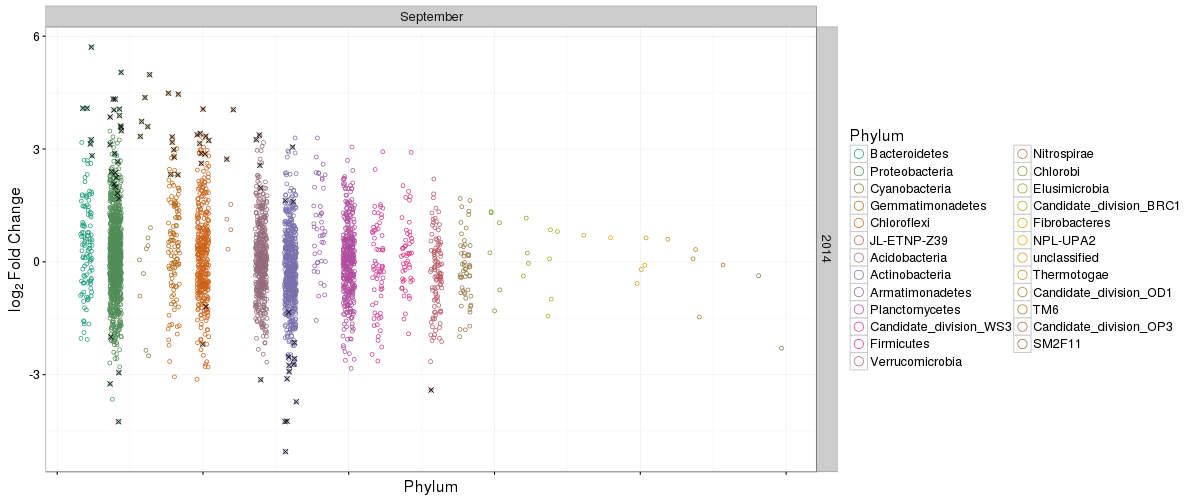

In [48]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_grid(Year~Month)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= 0.10), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) #+ guides(color = FALSE)

p

In [100]:
%%R
df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Rank2, Till) %>% summarise(counts = n()) %>% ungroup %>% 
            arrange(Rank2, -counts) %>% as.data.frame

              Rank2 Till counts
1     Acidobacteria   PT      4
2     Acidobacteria   NT      1
3    Actinobacteria   NT     12
4    Actinobacteria   PT      3
5     Bacteroidetes   PT      6
6       Chloroflexi   PT      9
7       Chloroflexi   NT      2
8     Cyanobacteria   PT      5
9  Gemmatimonadetes   PT      8
10      JL-ETNP-Z39   PT      2
11   Proteobacteria   PT     20
12   Proteobacteria   NT      4
13  Verrucomicrobia   NT      1


In [52]:
%%R
re = filter(df.l2fc, padj2 <=0.10)
length(unique(re$OTU))

[1] 77
